gg-napari-env

In [1]:
import napari
from napari_czifile2 import napari_get_reader
from cellpose import models, plot, utils, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import pandas as pd
import skimage.exposure as exposure
from skimage.morphology import remove_small_objects
import numpy as np
from skimage.measure import label, regionprops
import seaborn as sns
import os 
import sys 
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion, gaussian_filter, binary_dilation, binary_fill_holes
from skimage import exposure
import sys 
from plotting import * 
import warnings
import matplotlib.font_manager as fm
fm.fontManager.__init__()
warnings.filterwarnings("ignore")
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

Initializing plotting package
>>> GPU activated? 1
2025-03-24 16:58:14,103 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-03-24 16:58:14,104 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

In [3]:
input = '20250324 A1 stacks'
input_dir = f'../raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")

Found 3 czi files in ../raw-data/20250324 A1 stacks/


In [4]:
file = czi_files[0]
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../raw-data/20250324 A1 stacks/20250324 A1 Stack 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 100, 4, 2048, 2048)


In [5]:
# Export to a folder for training 
output_dir = f"../cellpose-model-training/{file.replace(".czi", "")} slices"
os.makedirs(output_dir, exist_ok=True)

# Sizes of zooms 
n_slices = 5 
np.random.seed(0)
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
slices = np.random.choice(image_data.shape[1], n_slices)
for i, s in enumerate(slices):
    slice_data = image_data[0,s,dapi_index,:,:]
    io.imsave(f"{output_dir}/{file.replace(".czi", f"_{i}.tif")}", slice_data)
    print(f"Saved {output_dir}/{file.replace('.czi', f'_{i}.tif')}")

Saved ../cellpose-model-training/20250307 C2 sample 1 stack slices/20250307 C2 sample 1 stack_0.tif
Saved ../cellpose-model-training/20250307 C2 sample 1 stack slices/20250307 C2 sample 1 stack_1.tif
Saved ../cellpose-model-training/20250307 C2 sample 1 stack slices/20250307 C2 sample 1 stack_2.tif
Saved ../cellpose-model-training/20250307 C2 sample 1 stack slices/20250307 C2 sample 1 stack_3.tif
Saved ../cellpose-model-training/20250307 C2 sample 1 stack slices/20250307 C2 sample 1 stack_4.tif


In [5]:
pixel_x = metadata['scale'][2]
print(f"Pixel size: {pixel_x} um")

nucleus_diameter = 3 / pixel_x
print(f"Nucleus diameter: {nucleus_diameter} pixels") 

Pixel size: 0.0974884033203125 um
Nucleus diameter: 30.77289090624511 pixels


In [6]:
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
z_index = image_data.shape[1] // 2
dapi_image = image_data[0, z_index, dapi_index, :, :]
dapi_image.shape

(2048, 2048)

In [7]:
# Load trained model 
model_path = '../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs'
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

2025-03-24 16:59:00,873 [INFO] ** TORCH CUDA version installed and working. **
2025-03-24 16:59:00,874 [INFO] >>>> using GPU (CUDA)
2025-03-24 16:59:01,020 [INFO] >>>> loading model ../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs
2025-03-24 16:59:02,010 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-03-24 16:59:02,011 [INFO] >>>> model diam_labels =  30.133 (mean diameter of training ROIs)


In [8]:
def random_colormap_transparent(mask):
    unique_labels = np.unique(mask)
    colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # RGBA image

    # Assign random colors
    np.random.seed(0)  # Ensure reproducibility
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3), dtype=np.uint8)
    colors = np.hstack((colors, np.full((len(unique_labels), 1), 255, dtype=np.uint8)))  # Add full opacity

    colors[0] = [0, 0, 0, 0]  # Make background transparent

    for i, label in enumerate(unique_labels):
        colored_mask[mask == label] = colors[i]

    return colored_mask

In [9]:
def filter_eccentricity(rois, max_eccentricity = 0.9): 
    labeled_mask = label(rois > 0)  # Convert to binary before labeling

    # Create empty array for filtered regions
    filtered_rois = np.zeros_like(labeled_mask, dtype=np.uint16)

    # Filter objects based on eccentricity 
    for region in regionprops(labeled_mask):
        if region.eccentricity < max_eccentricity:  # 
            filtered_rois[labeled_mask == region.label] = region.label  # Keep original labels
    
    return filtered_rois

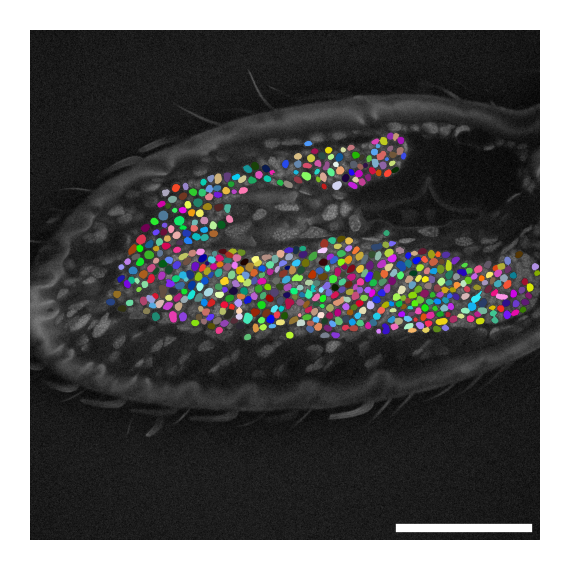

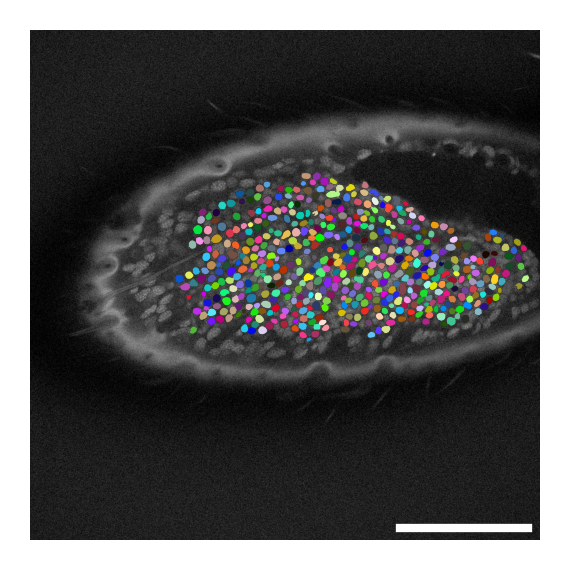

2025-03-24 16:59:57,886 [INFO] No cell pixels found.


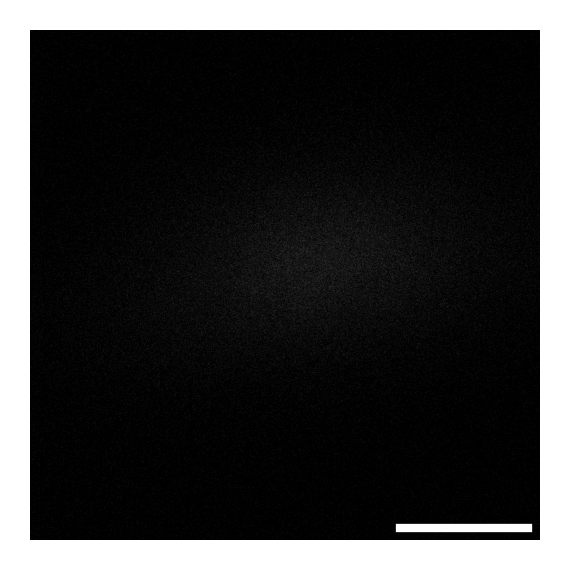

In [12]:
# choose 6 random zs 
num_z = 3
np.random.seed(8)
z_slices = image_data.shape[1]
z_indices = np.random.choice(range(z_slices), num_z)
#z_indices = [30]
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
gamma = 0.5  # <1 to brighten, >1 to darken

# Plot each channel for each z slice and the masks
for i, z in enumerate(z_indices):
    img = image_data[0, z, dapi_index, :, :]    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300) 
    ax.imshow(exposure.adjust_gamma(img, gamma), cmap='gray')
    rois, flows, styles = model.eval(img, diameter=nucleus_diameter)
    #filtered_rois = filter_eccentricity(rois)
    ax.imshow(random_colormap_transparent(rois)) 
    ax.axis('off')

    # Get scale for scale bar 
    x_scale = 50 / metadata['scale'][2] # 5 um in pixels 
    ax.plot([img.shape[1] - 50 - x_scale, img.shape[1] - 50], [img.shape[0] - 50, img.shape[0] - 50], color='white', lw=2)
    plt.tight_layout() 
    #plt.savefig(f"../figures/OOS-examples/{file.replace('.czi', f'_z{z}.pdf')}", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

In [13]:
results_dir = f'../results/{input}'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for f in czi_files[:1]:
    print(f"Processing {f}")
    file_path = os.path.join(input_dir, f)
    reader = napari_get_reader(file_path)
    if reader is not None:
        layer_data = reader(file_path)
        image_data, metadata, layer_type = layer_data[0]
        print("Metadata:", metadata)
        print("Image shape:", image_data.shape)  
        print(f"Number of NaN pixels: {np.sum(np.isnan(image_data))}")

        pixel_x = metadata['scale'][2]
        print(f"Pixel size: {pixel_x} um")

        xy_resolution = image_data.shape[-1] 
        print(f"XY resolution: {xy_resolution} pixels")

        nucleus_diameter = 3 / pixel_x
        print(f"Nucleus diameter: {nucleus_diameter} pixels") 
        
        z_slices = image_data.shape[1]
        print(f"Z slices: {z_slices}")

        z_um = metadata['scale'][1]
        print(f"Z resolution: {z_um} um")

        dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
        print(f"DAPI channel index: {dapi_index}")

        non_dapi_channels = [(i, metadata['name'][i]) for i in range(len(metadata['name'])) if i != dapi_index]
        print(f"Non-DAPI channels: {non_dapi_channels}")

        nucleus_count = 0 
        results = [] 
        all_rois = np.zeros_like(image_data[0, :, dapi_index, :, :], dtype=np.uint16)
        for z in range(z_slices):
            print(f"Processing z={z}")
            image_data_z = image_data[0, z, dapi_index, :, :]
            rois, flows, styles = model.eval(image_data_z, diameter=nucleus_diameter)
            print(f"Identified {rois.max()} nuclei")
            all_rois[z, :, :] = rois
            #masks = filter_eccentricity(masks)

            # Quantify the average intensity in the other channels for each nucleus
            # Iterate over each nucleus, and measure the average intensity in the other channels and save to results a dictionary with the following keys:
            # nucleus id, nucleus area, nucleus centroid coordinates, average intensity in each channel
            regions = regionprops(rois)
            for region in regions: 
                nucleus_result = {} 
                nucleus_result['z_id'] = region.label
                nucleus_result['image'] = f
                nucleus_result['z'] = z
                nucleus_result['count'] = nucleus_count
                nucleus_result['area'] = region.area * pixel_x**2
                # x and y are flipped in the regionprops output
                nucleus_result['centroid_x'] = region.centroid[1] 
                nucleus_result['centroid_y'] = region.centroid[0]
                for channel, channel_name in non_dapi_channels:
                    nucleus_result[channel_name] = np.nanmean(image_data[0, z, channel, rois == region.label])
                results.append(nucleus_result)
                nucleus_count += 1
        
        # Export results to a CSV file
        results = pd.DataFrame(results)
        results_path = os.path.join(results_dir, f.replace('.czi', '.csv'))
        results.to_csv(results_path, index=False)
        print(f"Results saved to {results_path}")

        # Save the masks to a file 
        all_rois_path = os.path.join(results_dir, f.replace('.czi', f'_rois.npy'))
        np.save(all_rois_path, all_rois)
        print(f"ROIs saved to {all_rois_path}")

Processing 20250324 A1 Stack 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 100, 4, 2048, 2048)
Number of NaN pixels: 0
Pixel size: 0.0974884033203125 um
XY resolution: 2048 pixels
Nucleus diameter: 30.77289090624511 pixels
Z slices: 100
Z resolution: 1.0 um
DAPI channel index: 2
Non-DAPI channels: [(0, 'AF546-T1'), (1, 'AF488-T2'), (3, 'AF647-T3')]
Processing z=0
2025-03-24 17:00:31,476 [INFO] No cell pixels found.
Identified 0 nuclei
Processing z=1
2025-03-24 17:00:32,006 [INFO] No cell pixels found.
Identified 0 nuclei
Processing z=2
2025-03-24 17:00:32,499 [INFO] No cell pixels found.
Identified 0 nuclei
Processing z=3
2025-03-24 17:00:33,005 [INFO] No cell pixels found.
Identified 0 nuclei
Processing z=4
2025-03-24 17:00:33,499 [INFO] No cell pixels found.
Identified 0 nuclei
Processing

A1: 9E129-B3-488 & LOC105275104-B1-546 & 9E116-B2-647 & DAPI

C1 and C2: 9E338-B3-488 & 9E306-B1-546 & 9E196-B2-647 & DAPI

B.1. U34-B3-546 & Chymotrypsin-B2-647 & DAPI

In [15]:
results_dir = f'../results/{input}'

In [16]:
# Load all results 
results = pd.DataFrame() 
for f in czi_files:
    results_path = os.path.join(results_dir, f.replace('.czi', '.csv'))
    if not os.path.exists(results_path):
        continue
    image_results = pd.read_csv(results_path)
    image_results.columns = image_results.columns.str.split('-T').str[0]
    # Remove .czi from 'image' column values
    image_results['image'] = image_results['image'].str.replace('.czi', '')
    results = pd.concat([results, image_results], axis=0) 
results

z_id                image   z  count      area   centroid_x  \
0         1  20250324 A1 Stack 3  25      0  6.377176  1066.043219   
1         2  20250324 A1 Stack 3  25      1  7.707735  1025.303329   
2         3  20250324 A1 Stack 3  25      2  9.542005  1323.934263   
3         4  20250324 A1 Stack 3  25      3  7.004440  1051.400271   
4         5  20250324 A1 Stack 3  25      4  8.211446  1008.699074   
...     ...                  ...  ..    ...       ...          ...   
33250     4  20250324 A1 Stack 3  98  33250  3.925147  1512.043584   
33251     1  20250324 A1 Stack 3  99  33251  7.574679  1766.338770   
33252     2  20250324 A1 Stack 3  99  33252  5.673881  1753.777219   
33253     3  20250324 A1 Stack 3  99  33253  6.168089  1497.941448   
33254     4  20250324 A1 Stack 3  99  33254  6.491224  1623.686676   

       centroid_y     AF546     AF488     AF647  
0      861.311475  3.961252  4.250373  4.563338  
1      862.487053  5.342787  4.622688  4.288533  
2      873.600598  4.364542  4.193227  4.249004  
3      890.858887  4.704206  4.758480  5.175034  
4      894.730324  4.383102  4.587963  4.503472  
...           ...       ...       ...       ...  
33250  926.791768  8.772397  2.372881  2.830508  
33251  669.893350  3.698871  2.294856  3.180678  
33252  708.127303  3.510888  2.015075  3.118928  
33253  894.070878  3.673344  2.656394  3.964561  
33254  920.385066  4.783309  2.811127  3.030747  

[33255 rows x 10 columns]

In [17]:
# Count nan rows 
results.isnull().any(axis=1).sum()

0

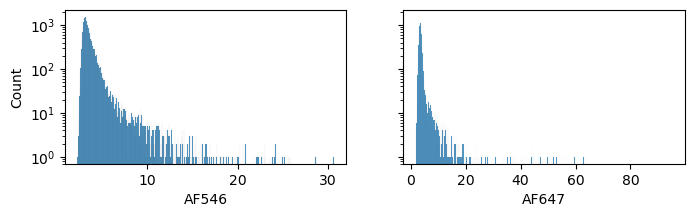

In [18]:
# Plot histograms of AF546 and AF647 intensities
f, axs = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
sns.histplot(data=results, x='AF546', ax=axs[0])
sns.histplot(data=results, x='AF647', ax=axs[1])
plt.yscale('log')
plt.show()

IndexError: list index out of range

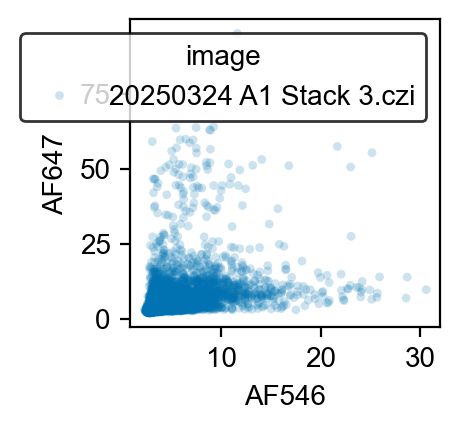

In [28]:
channel1, channel2 = "AF546", "AF647"
# U34-B3-546 & Chymotrypsin-B2-647 & DAPI (chymotrypsin = LOC105276652)
# 9E338-B3-488 & 9E306-B1-546 & 9E196-B2-647 & DAPI
#c1_name, c2_name = "U34", "LOC105276652"
# 9E129-B3-488 & LOC105275104-B1-546 & 9E116-B2-647 & DAPI
c1_name, c2_name = "LOC105275104", "9E116"

#results['image_number'] = results['image'].apply(lambda x: int(x.lower().split('stack')[0].split("sample ")[1]))
#results['image_number'] = results['image_number'].astype(int)
#results = results.sort_values(by='image_number')

f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
sns.scatterplot(data=results, x=channel1, y=channel2, s=10, ax=ax, hue='image', alpha=0.2, lw=0, palette='colorblind') 
handles, labels = ax.get_legend_handles_labels()
for lh in handles: 
    lh.set_alpha(1)
ax.legend(handles=handles, labels=[l.split('Stack')[0].split("B1 ")[1] for l in labels], fontsize=6, frameon=False, loc='upper right', handletextpad=0)
ax.set_xlabel(f"Mean {c1_name} Intensity", fontsize=6)
ax.set_ylabel(f"Mean {c2_name} Intensity", fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
#plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{c1_name}-{c2_name}-all-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

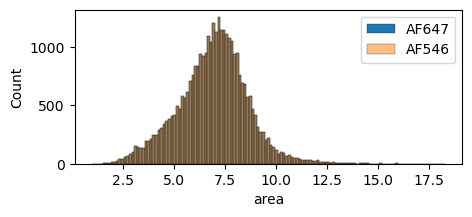

In [23]:
# Plot a histogram of area for each nucleus, for both 9E306+ and 9E196+ cells
f, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.histplot(data=results[results['AF647'] > 1], x='area', ax=ax, alpha=1, label='AF647')
sns.histplot(data=results[results['AF546'] > 1], x='area', ax=ax, alpha=0.5, label='AF546')
plt.legend()
plt.show()

In [24]:
# Load single results file  
results_dir = f'../results/{input}'
file = czi_files[0]
results_path = os.path.join(results_dir, file.replace('.czi', '.csv'))
results = pd.read_csv(results_path)
results.columns = results.columns.str.split('-T').str[0]
results

z_id                    image   z  count      area   centroid_x  \
0         1  20250324 A1 Stack 3.czi  25      0  6.377176  1066.043219   
1         2  20250324 A1 Stack 3.czi  25      1  7.707735  1025.303329   
2         3  20250324 A1 Stack 3.czi  25      2  9.542005  1323.934263   
3         4  20250324 A1 Stack 3.czi  25      3  7.004440  1051.400271   
4         5  20250324 A1 Stack 3.czi  25      4  8.211446  1008.699074   
...     ...                      ...  ..    ...       ...          ...   
33250     4  20250324 A1 Stack 3.czi  98  33250  3.925147  1512.043584   
33251     1  20250324 A1 Stack 3.czi  99  33251  7.574679  1766.338770   
33252     2  20250324 A1 Stack 3.czi  99  33252  5.673881  1753.777219   
33253     3  20250324 A1 Stack 3.czi  99  33253  6.168089  1497.941448   
33254     4  20250324 A1 Stack 3.czi  99  33254  6.491224  1623.686676   

       centroid_y     AF546     AF488     AF647  
0      861.311475  3.961252  4.250373  4.563338  
1      862.487053  5.342787  4.622688  4.288533  
2      873.600598  4.364542  4.193227  4.249004  
3      890.858887  4.704206  4.758480  5.175034  
4      894.730324  4.383102  4.587963  4.503472  
...           ...       ...       ...       ...  
33250  926.791768  8.772397  2.372881  2.830508  
33251  669.893350  3.698871  2.294856  3.180678  
33252  708.127303  3.510888  2.015075  3.118928  
33253  894.070878  3.673344  2.656394  3.964561  
33254  920.385066  4.783309  2.811127  3.030747  

[33255 rows x 10 columns]

In [25]:
# Load Image 
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../raw-data/20250324 A1 stacks/20250324 A1 Stack 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 100, 4, 2048, 2048)


In [26]:
# Load ROIs 
all_rois_path = os.path.join(results_dir, file.replace('.czi', '_rois.npy'))
all_rois = np.load(all_rois_path)
all_rois.shape

(100, 2048, 2048)

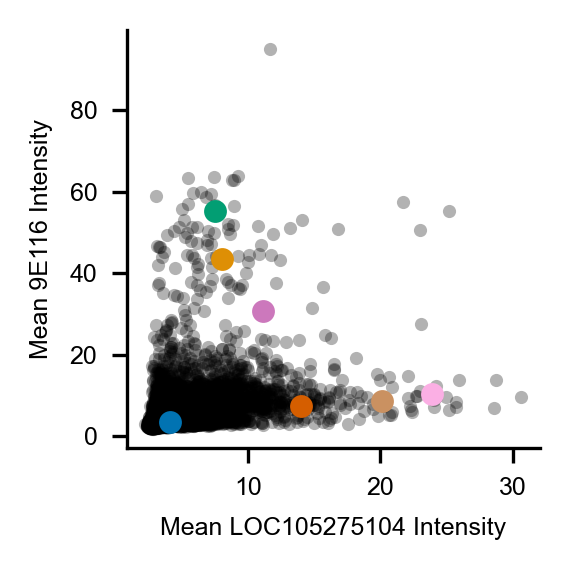

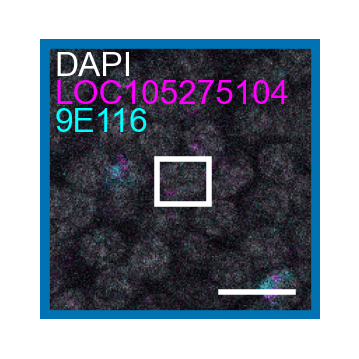

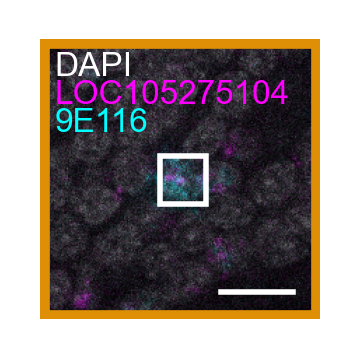

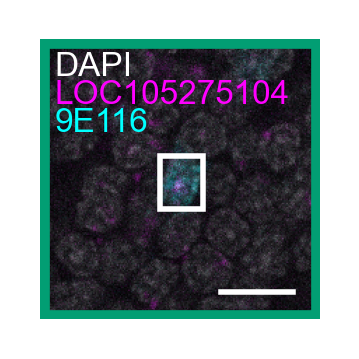

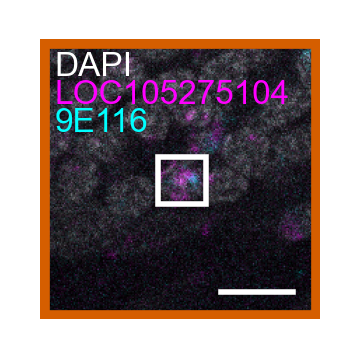

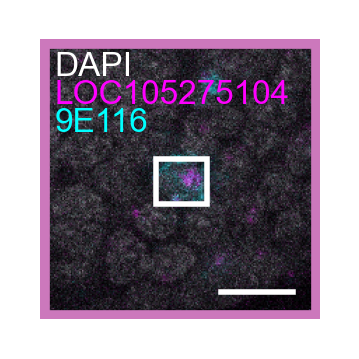

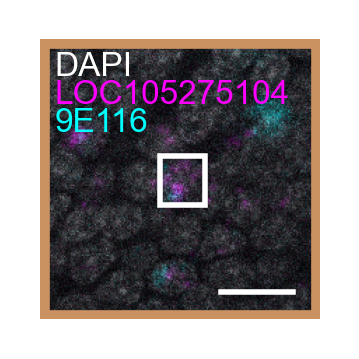

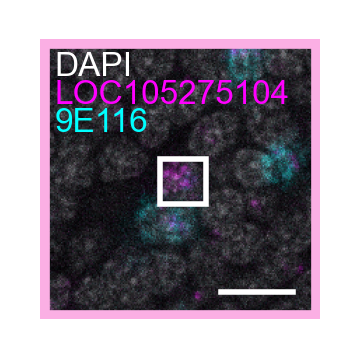

In [31]:
channel1, channel2 = "AF546", "AF647"
# U34-B3-546 & Chymotrypsin-B2-647 & DAPI (chymotrypsin = LOC105276652)
# 9E338-B3-488 & 9E306-B1-546 & 9E196-B2-647 & DAPI
#c1_name, c2_name = "9E306", "9E196"
#c1_name, c2_name = "U34", "LOC105276652"
c1_name, c2_name = "LOC105275104", "9E116"
pixel_bounds = 100

# Figure 
figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-examples'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
# clear directory 
for f in os.listdir(figure_dir):
    os.remove(os.path.join(figure_dir, f))

# Multipliers for each channel
clip_limit = 0.01

def auto_contrast(img, low_percentile=0.1, high_percentile=99.9):
    """
    Adjusts contrast by stretching pixel values based on percentile clipping.

    Parameters:
        img (np.ndarray): Input grayscale image.
        low_percentile (float): Lower percentile to clip (default: 0.02%).
        high_percentile (float): Upper percentile to clip (default: 99.98%).

    Returns:
        np.ndarray: Contrast-adjusted image.
    """
    # Compute lower and upper intensity limits
    p_low, p_high = np.percentile(img, (low_percentile, high_percentile))
    
    # Clip and scale values to [0,1]
    img_stretched = np.clip(img, p_low, p_high)
    img_stretched = (img_stretched - p_low) / (p_high - p_low) if p_high > p_low else img_stretched
    
    return img_stretched

# Bins 
n_bins = 4
results['channel1_bins'] = pd.cut(results[channel1], bins=np.linspace(results[channel1].min(), results[channel1].max(), n_bins + 1), labels=False, include_lowest=True)
results['channel2_bins'] = pd.cut(results[channel2], bins=np.linspace(results[channel2].min(), results[channel2].max(), n_bins + 1), labels=False, include_lowest=True)

# Get scale for scale bar 
x_scale = 5 / metadata['scale'][2] # 5 um in pixels 

# Plot a scatter plot of the two channels, with each nucleus colored by the image it came from
white_plotting()
random_colors = sns.color_palette('colorblind', n_bins**2)
f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 300) 
sns.scatterplot(data=results, x=channel1, y=channel2, s=10, ax=ax, color='black', alpha=0.3, lw=0)
c = 1
cells = [] 
for i in range(n_bins):
    for j in range(n_bins):
        subset = results[(results['channel1_bins'] == i) & (results['channel2_bins'] == j) & (results['area'] > 8)]
        if subset.empty:
            continue
        np.random.seed(0)
        cell = subset.sample(1)
        sns.scatterplot(data=cell, x=channel1, y=channel2, s=30, ax=ax, color=random_colors[c-1], lw=0, alpha=1)
        cells.append(cell)
        c += 1  

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"Mean {c1_name} Intensity", fontsize=6) 
ax.set_ylabel(f"Mean {c2_name} Intensity", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()
#plt.savefig(f"{figure_dir}/{file.replace('.czi', '_scatter.png')}", format="png", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", channel1, channel2]])]

for i, cell in enumerate(cells):
    # Retrieve image and z slice 
    x_bounds = int(cell['centroid_x'].values[0]) - pixel_bounds, int(cell['centroid_x'].values[0]) + pixel_bounds 
    y_bounds = int(cell['centroid_y'].values[0]) - pixel_bounds, int(cell['centroid_y'].values[0]) + pixel_bounds 
    image = image_data[0, cell['z'].values[0], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]] # 3 x 101 x 101

    # Create an RGB image
    rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=float)  # (height, width, 3)

    # Assign colors:
    # Gray → All RGB channels get the first dimension with gamma correction
    dapi = [i for i, channel in channels if 'DAPI' in channel][0]
    dapi_adjusted = auto_contrast(image[dapi]) 
    rgb_image[..., 0] += dapi_adjusted  # Red
    rgb_image[..., 1] += dapi_adjusted  # Green
    rgb_image[..., 2] += dapi_adjusted  # Blue

    # Magenta → Red + Blue from second dimension with gamma correction
    c1 = [i for i, channel in channels if channel1 in channel][0]
    c1_adjusted = auto_contrast(image[c1])
    rgb_image[..., 0] += c1_adjusted  # Red
    rgb_image[..., 2] += c1_adjusted  # Blue

    # Cyan → Green + Blue from third dimension with gamma correction
    c2 = [i for i, channel in channels if channel2 in channel][0]
    c2_adjusted = auto_contrast(image[c2])
    rgb_image[..., 1] += c2_adjusted  # Green
    rgb_image[..., 2] += c2_adjusted  # Blue

    # Rescale the image to 0-1
    rgb_image = rgb_image / np.max(rgb_image)  # Normalize based on max value

    # Clip: set values below 0 to 0 and above 1 to 1
    rgb_image = np.clip(rgb_image, 0, 1)

    # Display the image
    f, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=400)
    ax.imshow(rgb_image)
    ax.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # Add border to image with the color random_colors[i]
    ax.add_patch(plt.Rectangle((0, 0), image.shape[2]-1, image.shape[1]-1, fill=False, edgecolor=random_colors[i], lw=3))

    # Add text legend for each channel
    ax.text(10, 25, "DAPI", color='white', fontsize=6) 
    ax.text(10, 45, c1_name, color='magenta', fontsize=6)
    ax.text(10, 65, c2_name, color='cyan', fontsize=6)

    # Load ROIs 
    rois = all_rois[cell['z'].values[0], :, :]
    regions = regionprops(rois)
    region_labels = [region.label for region in regions]
    region = regions[region_labels.index(cell['z_id'].values[0])]
    bbox = region.bbox
    bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0], bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
    ax.add_patch(plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], fill=False, edgecolor='white', lw=1))
    
    # Add scale bar 
    ax.plot([2*pixel_bounds-20-x_scale, 2*pixel_bounds-20], [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
    
    plt.tight_layout()
    #plt.savefig(f"{figure_dir}/{file.replace('.czi', f'_cell_{i}.png')}", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

220 - AF546-T1: 3.07
220 - DAPI-T3: 24.16
220 - AF647-T3: 4.95
379 - AF546-T1: 2.79
379 - DAPI-T3: 25.36
379 - AF647-T3: 3.28


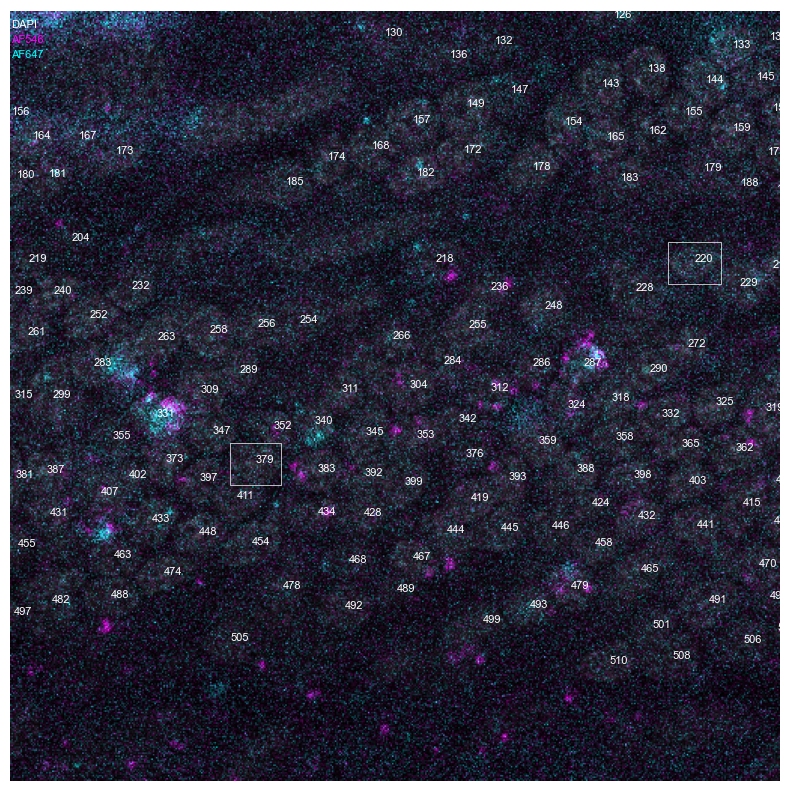

In [30]:
# Plot zoom-in of a random z plane and label the ROIs with numbers
channel1 = "AF546" 
channel2 = "AF647"
channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", channel1, channel2]])]

z = image_data.shape[1] // 2 + 10
size = 512 
x = image_data.shape[-1] // 2 - size // 2
y = image_data.shape[-1] // 2 - size // 2
image = image_data[0, z, :, x:x+size, y:y+size]

# Create an RGB image
rgb_image = np.zeros((image.shape[1], image.shape[2], 3))  # (height, width, 3)

# Assign colors:
# Gray → All RGB channels get the first dimension
dapi = [i for i, channel in channels if 'DAPI' in channel][0]
rgb_image[..., 0] += image[dapi]  # Red
rgb_image[..., 1] += image[dapi]  # Green
rgb_image[..., 2] += image[dapi]  # Blue

# Magenta → Red + Blue from second dimension
c1 = [i for i, channel in channels if channel1 in channel][0]
rgb_image[..., 0] += image[c1]  * 5 # Red
rgb_image[..., 2] += image[c1]  * 5 # Blue

# Cyan → Green + Blue from third dimension
c2 = [i for i, channel in channels if channel2 in channel][0]
rgb_image[..., 1] += image[c2] * 5 # Green
rgb_image[..., 2] += image[c2] * 5 # Blue

# Clip at 255 
rgb_image = np.clip(rgb_image, 0, 255)

# Rescale the image to 0-1
rgb_image = rgb_image / 255

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(rgb_image, cmap='gray')

rois = all_rois[z, x:x+size, y:y+size]
regions = regionprops(rois)
for region in regions:
    ax.text(region.centroid[1], region.centroid[0], region.label, color='white', size=8)

# Add text legend for each channel
ax.text(0, 10, "DAPI", color='white', fontsize=8) 
ax.text(0, 20, channel1, color='magenta', fontsize=8)
ax.text(0, 30, channel2, color='cyan', fontsize=8)

rois = [220, 379]
for roi in rois: 
    cell = results[(results['z'] == z) & (results['z_id'] == roi)]
    region_labels = [region.label for region in regions]
    region = regions[region_labels.index(roi)]
    bbox = region.bbox
    ax.add_patch(plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], fill=False, edgecolor='white', lw=0.5))
    for c, channel in channels: 
        avg_intensity = np.nanmean(image_data[0, z, c, all_rois[z] == roi])
        print(f"{roi} - {channel}: {avg_intensity:.2f}")

ax.axis('off')
plt.show()

In [130]:
region.area

754.0